# Соревнование: San Francisco Crime Classification

_Given time and location, you must predict the category of crime that occurred. Kaggle is hosting this competition for the machine learning community to use for fun and practice._

https://www.kaggle.com/c/sf-crime

## 1. Подготовка работы. Загрузка библиотек и настройка отображения
Импорты и настроийки, которые необходимы для шаблона.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
import time
import datetime

%matplotlib inline

## 2. Загрузка, очистка данных. Exploratory data analysis.

Загрузка тренировочных данных из csv:

In [2]:
train_data = pd.read_csv('data/train.csv')

Просмотрим структуру данных:

In [3]:
train_data.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


Целевая переменная находится в столбце *Category*, ее и надо будет предсказать. Немного преобразуем данные, конвертируем строку дата в DateTime объект, а другие столбцы конвертируем в категориальные переменные.

In [4]:
train_data.Dates = pd.to_datetime(train_data.Dates)
train_data.Category = train_data.Category.astype('category')
train_data.Descript = train_data.Descript.astype('category')
train_data.DayOfWeek = train_data.DayOfWeek.astype('category')
train_data.PdDistrict = train_data.PdDistrict.astype('category')
train_data.Resolution = train_data.Resolution.astype('category')
train_data.Address = train_data.Address.astype('category')

In [5]:
train_data[['Category', 'Descript','DayOfWeek','PdDistrict','Resolution','Address']].describe()

,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address
count,878049,878049,878049,878049,878049,878049
unique,39,879,7,10,17,23228
top,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Friday,SOUTHERN,NONE,800 Block of BRYANT ST
freq,174900,60022,133734,157182,526790,26533


In [6]:
train_data[['X','Y']].describe()

,X,Y
count,878049.000000,878049.000000
mean,-122.422616,37.771020
std,0.030354,0.456893
min,-122.513642,37.707879
25%,-122.432952,37.752427
50%,-122.416420,37.775421
75%,-122.406959,37.784369
max,-120.500000,90.000000


Видно, что есть преступления со странными координатами -120, 90 возможно эти данные были занесены с ошибками. Посчитаем сколько у нас таких данных.

In [7]:
train_data[(train_data['X']==-120.5) & (train_data['Y']==90.0)].shape[0]

67

Всего таких записей 67, поэтому чтобы не портить нам регрессию, просто удалим эти строки.

In [8]:
train_data = train_data[(train_data['X']!=-120.5) | (train_data['Y']!=90.0)]

Построим гистограмму самых распространненых преступлений:

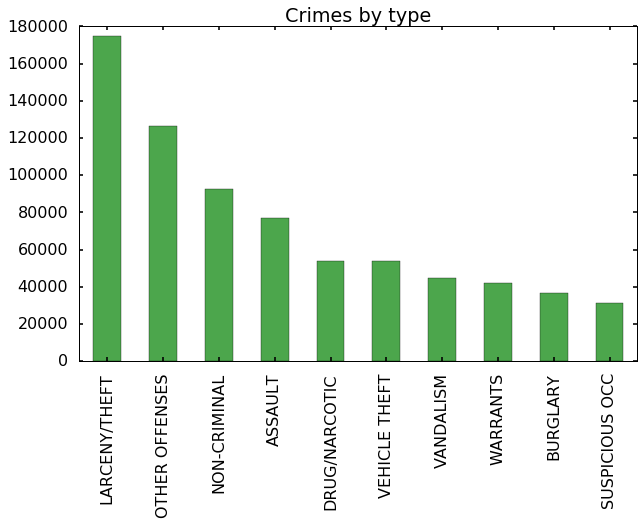

In [14]:
plt.figure(figsize=(10, 6))
train_data.Category.value_counts()[:10].plot(kind='bar', title='Crimes by type', color='green', alpha=0.7)
plt.show()

Остальные преступления:

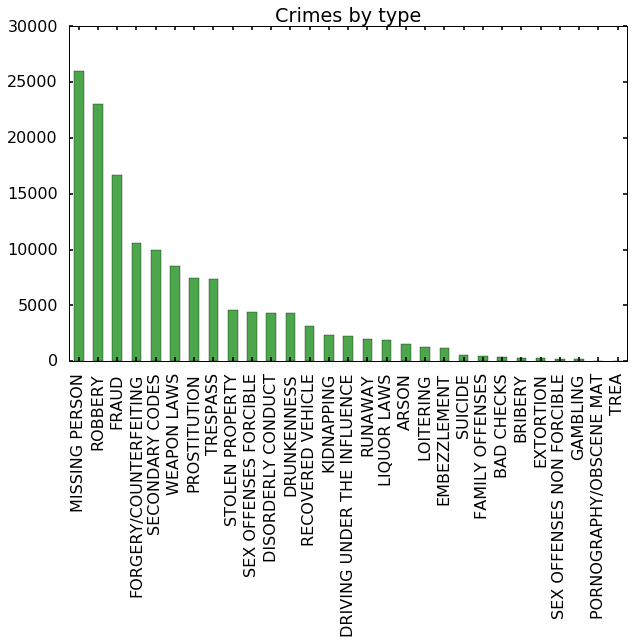

In [16]:
plt.figure(figsize=(10, 6))
train_data.Category.value_counts()[10:].plot(kind='bar', title='Crimes by type', color='green', alpha=0.7)
plt.show()

Разобьем нашу дату на час, день месяца, месяц и год, чтобы получить больше информации:

In [17]:
def convert_time(data):
    data['Hour'] = pd.Series([date.hour for date in data.Dates], dtype="category")
    data['Day'] = pd.Series([date.day for date in data.Dates], dtype="category")
    data['Month'] = pd.Series([date.month for date in data.Dates], dtype="category")
    data['Year'] = pd.Series([date.year for date in data.Dates], dtype="category")
    return data
train_data = convert_time(data)

Построим график зависимости количества преступлений от часа дня, дня месяца, дня недели, месяца и года:

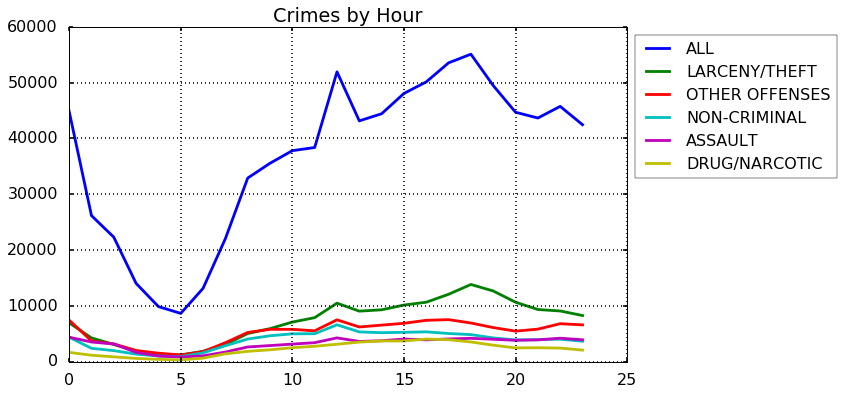

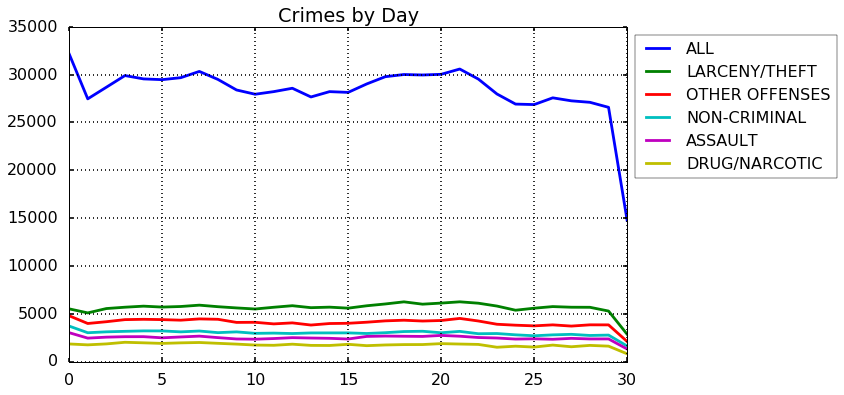

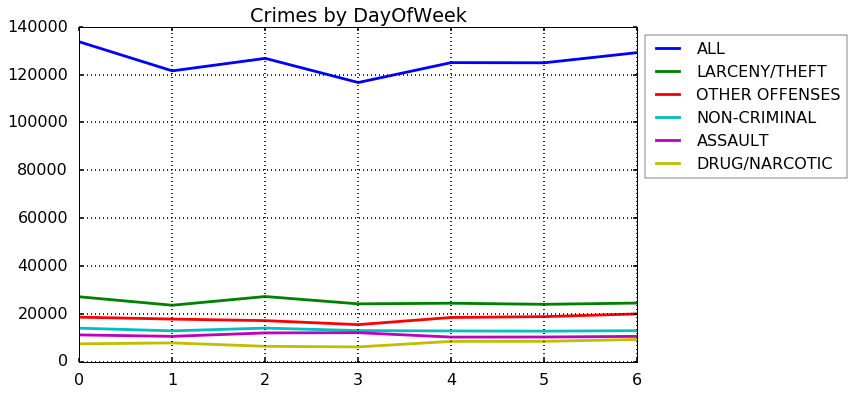

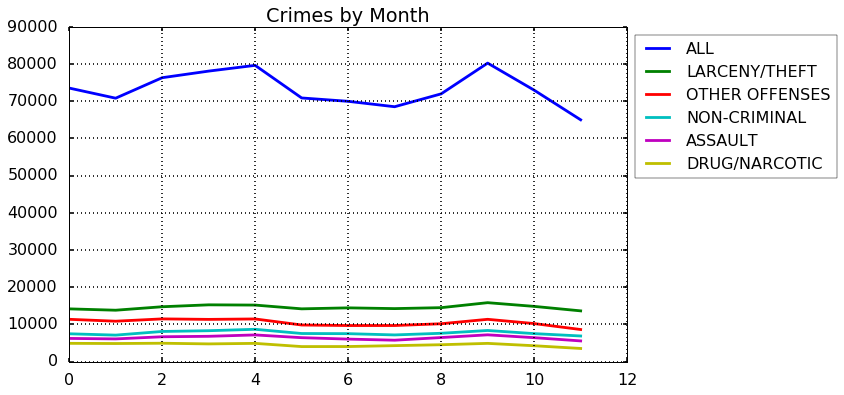

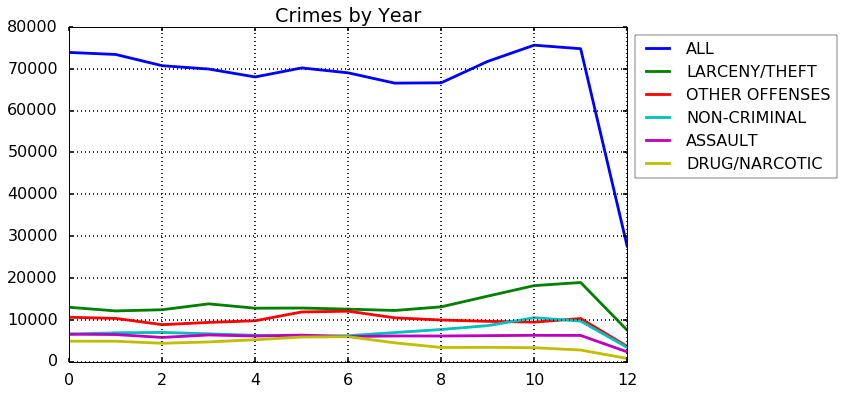

In [21]:
def plot_by_param(param):
    plt.figure(figsize=(10, 6))
    top5_categories = train_data.Category.value_counts().index[:5].tolist()
    plt.plot(train_data[param].value_counts().sort_index().tolist(), label='ALL')
    for cat in top5_categories:
        plt.plot(train_data[train_data.Category==cat][param].value_counts().sort_index().tolist(), label=cat)
    plt.legend(bbox_to_anchor=(1, 1), loc=2,)
    plt.title('Crimes by %s' % (param))
    plt.grid(True)
    
params = ['Hour','Day','DayOfWeek','Month','Year']
for param in params:
    plot_by_param(param)

Видно, что больше всего выражена зависимость числа преступлений от часа суток. Так же есть слабая зависимость некоторых преступлений от дня недели и от года.

Построим теперь карту преступлений:

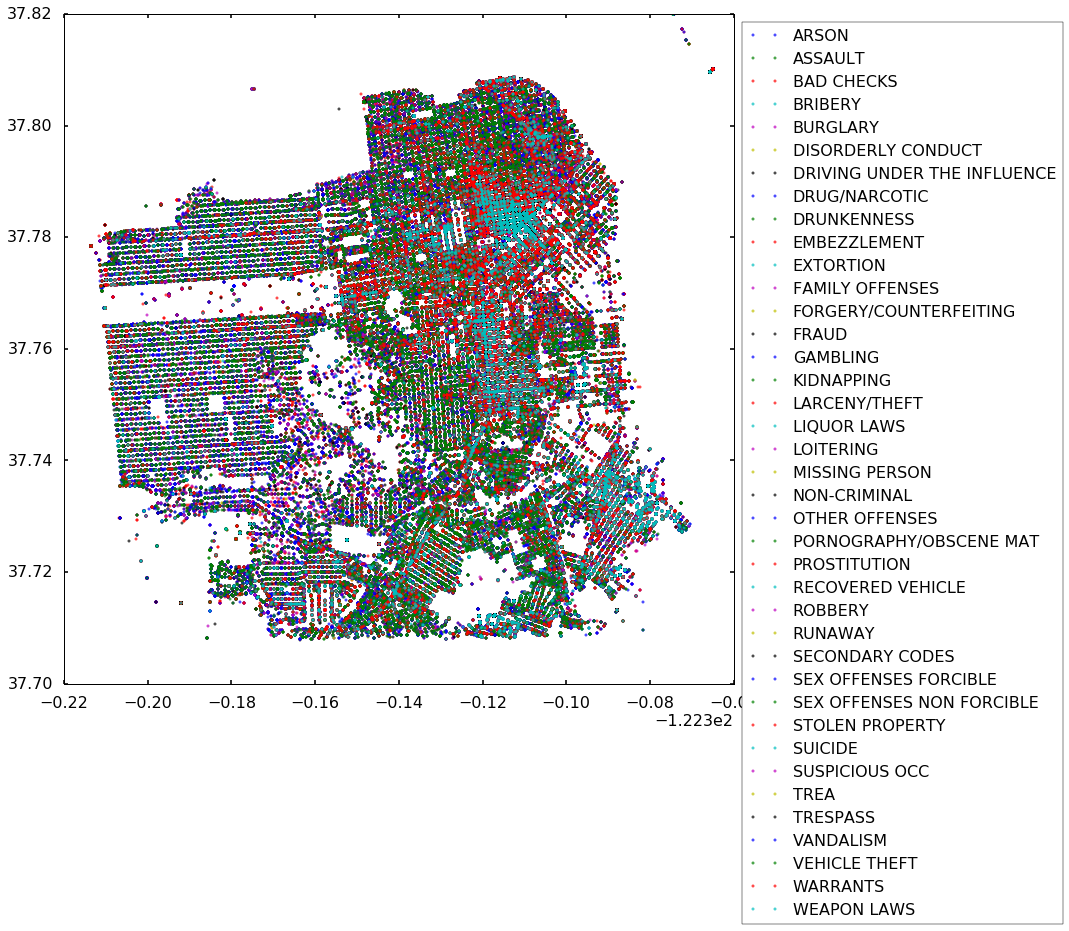

In [38]:
fig, ax = plt.subplots(figsize=(12, 12))
for cat in train_data.Category.cat.categories:
    ax.plot(train_data[train_data.Category==cat].X, train_data[train_data.Category==cat].Y, 
            marker='o', linestyle='', ms=3, alpha=0.7, label = cat)
ax.legend(bbox_to_anchor=(1, 1), loc=2,)

Попробуем построить такую же карту, но возьмем только первые 5 самые популярные виды преступлений:

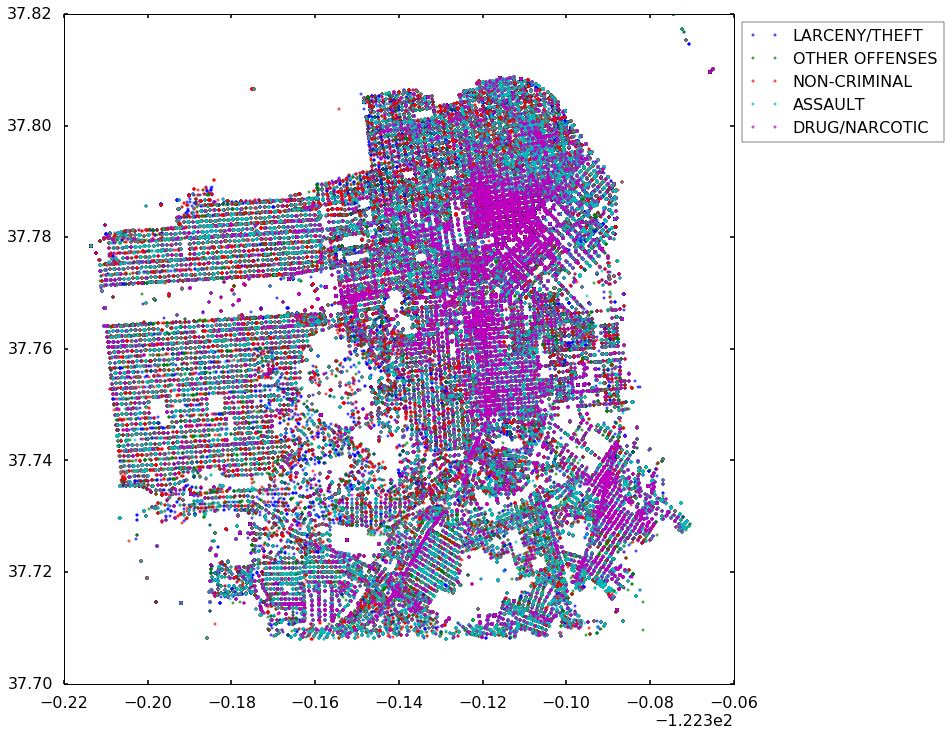

In [39]:
fig, ax = plt.subplots(figsize=(12, 12))
for cat in train_data.Category.value_counts().index[:5].tolist():
    ax.plot(train_data[train_data.Category==cat].X, train_data[train_data.Category==cat].Y, 
            marker='o', linestyle='', ms=3, alpha=0.7, label = cat)
ax.legend(bbox_to_anchor=(1, 1), loc=2,)

Видно, что некоторые преступления сгруппированы в большие кучи, это можно будет использовать.

Построим тепловую карту преступлений:

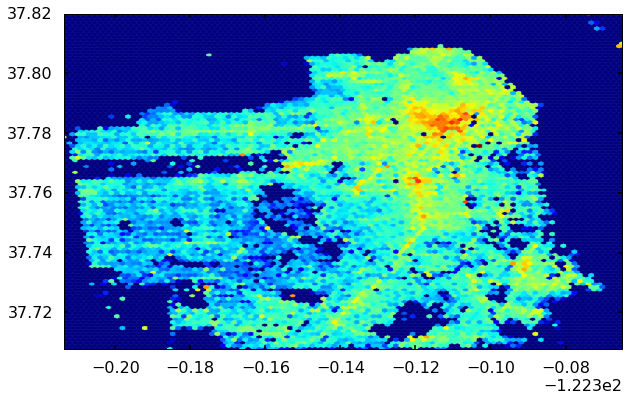

In [44]:
plt.figure(figsize=(10, 6))
plt.hexbin(train_data.X, train_data.Y, bins='log')

Видно, что больше всего преступлений в центре, но пока не особо понятно, как это знание поможет нам определять тип преступления.

## 3. Построение дополнительных признаков.

Напишем дополнительные функции, чтобы преобразовать наши данные.

In [46]:
from sklearn import preprocessing

In [61]:
fiature_converters = dict()

def feature_binarizer(data, feature_name, fit=False):
    if(fit):
        fiature_converters[feature_name]=preprocessing.LabelBinarizer()
        fiature_converters[feature_name].fit(data[feature_name])
    return fiature_converters[feature_name].transform(data[feature_name])

def conv_street(street):
    if street.find('/') != -1:
        return map(str.strip, street.split('/'))    
    pos = street.find('Block of ')
    if pos != -1:        
        return [street[pos+9:]]    
    return [street]

def build_streets(data):
    streets = set()
    for x in data.Address[0:10]:
        streets |= set(conv_street(x))
    return streets

def append_streets(adr_column, streets):
    streets_cols = np.zeros((len(adr_column),len(streets)), dtype=int)
    for i, street in enumerate(streets):
        for j, address in enumerate(adr_column):
            if address.find(street) != -1:
                streets_cols[j,i] = 1
    return streets_cols

streets = build_streets(train_data)

coords_scaler = preprocessing.MinMaxScaler()
def transform_coords(data,fit=False):
    if fit:
        coords_scaler.fit(data)
    return coords_scaler.transform(data)

In [62]:
X_train = np.hstack((transform_coords(train_data[['X', 'Y']].values,True),
                     feature_binarizer(train_data,'Hour',True),
                     feature_binarizer(train_data,'Day',True),
                     feature_binarizer(train_data,'Month',True),
                     feature_binarizer(train_data,'Year',True),
                     feature_binarizer(train_data,'DayOfWeek',True),
                     feature_binarizer(train_data,'Address',True),
                     append_streets(train_data.Address, streets),
                     feature_binarizer(train_data,'PdDistrict',True)))

ValueError: Unknown label type: (0         23
1         23
2         23
3         23
4         23
5         23
6         23
7         23
8         23
9         23
10        22
11        22
12        22
13        22
14        22
15        22
16        22
17        21
18        21
19        21
20        21
21        21
22        21
23        21
24        21
25        21
26        21
27        21
28        21
29        20
          ..
878019   NaN
878020   NaN
878021   NaN
878022   NaN
878023   NaN
878024   NaN
878025   NaN
878026   NaN
878027   NaN
878028   NaN
878029   NaN
878030   NaN
878031   NaN
878032   NaN
878033   NaN
878034   NaN
878035   NaN
878036   NaN
878037   NaN
878038   NaN
878039   NaN
878040   NaN
878041   NaN
878042   NaN
878043   NaN
878044   NaN
878045   NaN
878046   NaN
878047   NaN
878048   NaN
Name: Hour, dtype: category
Categories (24, int64): [0, 1, 2, 3, ..., 20, 21, 22, 23],)

In [54]:
append_coords(train_data.X.values,train_data.Y.values, True)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

array([ 0.5900988 ,  0.5900988 ,  0.60037861, ...,  0.64575232,
        0.64879882,  0.27059299])

In [58]:
append_coords2(train_data[['X', 'Y']].values,True)

array([[ 0.5900988 ,  0.59519781],
       [ 0.5900988 ,  0.59519781],
       [ 0.60037861,  0.825497  ],
       ..., 
       [ 0.74141433,  0.64575232],
       [ 0.82788754,  0.64879882],
       [ 0.79833688,  0.27059299]])

In [63]:
train_data['Hour'].cat.categories

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23],
           dtype='int64')